In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
"""Data Preprocessing"""

data = pd.read_csv("Churn_Modelling.csv")
data = data.drop(['CustomerId', 'Surname'], axis=1)
categorical_cols = ['Geography', 'Gender']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['Exited']]
A = data.drop('Exited', axis=1)
b = data['Exited']

In [6]:

"""Transforming/Scaling categorical and numerical data using OneHotEncoder and StandardScaler respectively"""

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [7]:
"""

Splitting training and testing data"""

A_train, A_test, b_train, b_test = train_test_split(A, b, test_size=0.3, random_state=42)
A_train = preprocessor.fit_transform(A_train)
A_test = preprocessor.transform(A_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
"""Create the model with necessary operations"""

def create_model(optimizer):
    model = Sequential()
    model.add(Dense(64, input_shape=(A_train.shape[1],), activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:

"""Model Compilation"""

optimizers = [SGD(), Adam(), RMSprop()]
for opt in optimizers:
    model = create_model(opt)
    print(f"Training model with {str(opt)} optimizer...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(A_train, b_train, epochs=10, batch_size=32, verbose=0)

Training model with <keras.src.optimizers.sgd.SGD object at 0x7a8839fbb4f0> optimizer...
Training model with <keras.src.optimizers.adam.Adam object at 0x7a8839d94490> optimizer...
Training model with <keras.src.optimizers.rmsprop.RMSprop object at 0x7a8839d95750> optimizer...


In [10]:

"""Accuracy Evaluation"""

loss, accuracy = model.evaluate(A_test, b_test, verbose=0)
print(f"Evaluation on test set with {str(opt)} optimizer:")
print(f"Loss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%")
b_pred = model.predict(A_test)
b_pred_classes = (b_pred > 0.5).astype("int32")

Evaluation on test set with <keras.src.optimizers.rmsprop.RMSprop object at 0x7a8839d95750> optimizer:
Loss: 0.3475, Accuracy: 86.33%
94/94 [==============================] - 0s 1ms/step


In [11]:

"""Confusion Matrix


"""

cm = confusion_matrix(b_test, b_pred_classes)
print("")
print("Confusion Matrix:")
print(cm)
print("Number of customers predicted by the model to stay : ",cm[0][0])
print("Number of customer predicted by the model to churn/exit : ",cm[1][1])


Confusion Matrix:
[[2365   51]
 [ 359  225]]
Number of customers predicted by the model to stay :  2365
Number of customer predicted by the model to churn/exit :  225


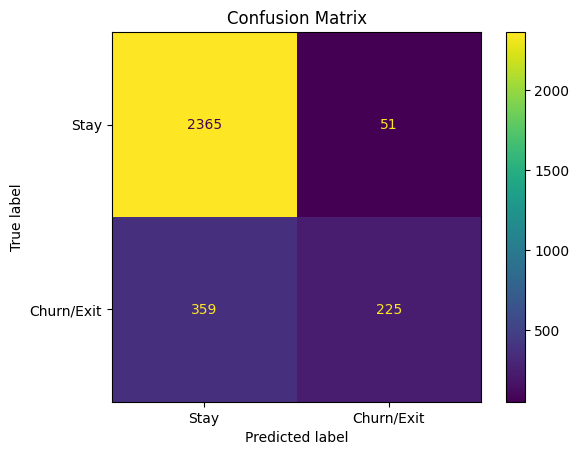

In [12]:
"""Visualization of Confusion Matrix"""

disp = ConfusionMatrixDisplay(cm, display_labels=['Stay','Churn/Exit'])
disp.plot()
plt.title('Confusion Matrix')
plt.show()